In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

In [104]:
%load_ext autoreload
%autoreload 2
from LSTM_model import LSTMClassifier
from LSTM_model2 import LSTMClassifier2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Current device: ", device)

Current device:  cuda


In [106]:
class SequenceDataset(Dataset):
    def __init__(self, features_file, labels_file, sequence_length=25):
        """
        This dataset class takes a sequence of input T-Stick data and cuts it up in sequence_length sized chunks (around 1 second of T-Stick Data)
        and assigns the average label value of each chunk as the label for that chunk.

        features_file: str path to the numpy file containing the T-Stick input Data
        labels_file: str path to the numpy file containing the binary labels for gesture detection
        sequence_length: int sliding window length
        """
        self.features = np.load(features_file)
        self.labels = np.load(labels_file)
        self.sequence_length = sequence_length        
        self.means = np.mean(self.features, axis=0)
        self.stds = np.std(self.features, axis=0)
        self.X, self.y = self.process_data()

    def process_data(self):
        # Normalize self.features parameters
        self.features = (self.features - self.means) / (self.stds + 1e-8)

        window_size = self.sequence_length
        num_windows = len(self.features) - window_size + 1
        X_processed = np.array([self.features[i:i+window_size] for i in range(num_windows)])
        y_processed = np.array([np.mean(self.labels[i:i+window_size]) for i in range(num_windows)])
        return torch.tensor(X_processed, dtype=torch.float32).to(device), torch.tensor(y_processed, dtype=torch.float32).to(device)
    
    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

In [107]:
sequence_length = 25 # Sequence length is a crucial hyperparameter, especially for the model's generalization

gestureNumber = 7
train_dataset = SequenceDataset('data/X' + str(gestureNumber) + '.npy', 'data/y' + str(gestureNumber) + '.npy', sequence_length=sequence_length)
test_dataset = SequenceDataset('data/X_test' + str(gestureNumber) + '.npy', 'data/y_test' + str(gestureNumber) + '.npy', sequence_length=sequence_length)

batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [108]:
# Define model parameters
num_sensors = train_dataset.X.shape[-1]
hidden_size = 512
learning_rate = 1e-5

# Instantiate the model
model = LSTMClassifier2(
    num_gestures=1,
    num_sensors=num_sensors,
    hidden_size=hidden_size,
    window_size=sequence_length,
    device=device         
)
model.to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [109]:
def train_model(data_loader, model, loss, opt):
    num_batches = len(data_loader)
    total_loss = 0

    model.train()
    for i, (X, y) in enumerate(data_loader):
        y_pred = model(X)
        loss_val = loss(y_pred, y)

        opt.zero_grad()
        loss_val.backward()
        opt.step()

        total_loss += loss_val.item()

    return total_loss/num_batches

def test_model(data_loader, model, loss):
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            y_pred = model(X)
            loss_val = loss(y_pred, y)
            total_loss += loss_val.item()

    return total_loss/num_batches

In [110]:
initial_loss = test_model(test_loader, model, criterion)
print(f"Initial Test Loss: {initial_loss:.4f}")

Initial Test Loss: 0.7061


Epoch 0/200
Epoch 20/200
Epoch 40/200
Epoch 60/200
Epoch 80/200
Epoch 100/200
Epoch 120/200
Epoch 140/200
Epoch 160/200
Epoch 180/200


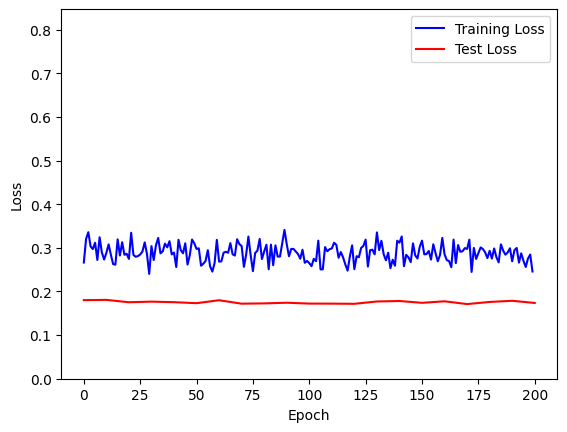

In [137]:
epochs = 200
losses = []
losses_test = []

for epoch in range(epochs):
    losses.append(train_model(train_loader, model, criterion, optimizer))
    if(epoch%(epochs/10)==0):
        print(f'Epoch {epoch}/{epochs}')
    if(epoch%10==0):
        losses_test.append(test_model(test_loader, model, criterion))
losses_test.append(test_model(test_loader, model, criterion))

plt.plot(losses, color='blue', label='Training Loss')
plt.plot(range(0, 10*len(losses_test), 10), losses_test, color='red', label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, initial_loss*1.2)
plt.legend()
plt.show()
    

In [134]:
# i is the initial chosen file
torch.save({
    'model_state_dict': model.state_dict(),
    'means': train_dataset.means,
    'stds': train_dataset.stds,
    }, 'models/gestureRecognition' + str(gestureNumber) + '.pth')

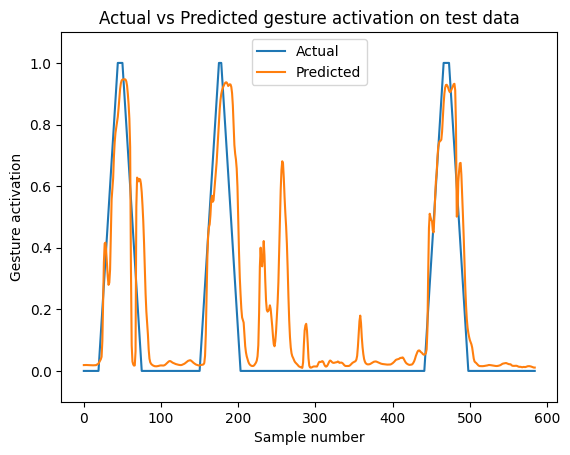

In [135]:
import random

# Get a batch from the test_loader
batches = list(test_loader)

y_pred = torch.zeros(0).to(device)
y_true = torch.zeros(0).to(device)
for batch in batches:
    X, y = batch
    y_true = torch.cat((y_true, y), dim=0)
    y_pred = torch.cat((y_pred, model(X)), dim=0)

y_plot = y_true.cpu().numpy()
y_pred_plot = y_pred.cpu().detach().numpy()

plt.plot(y_plot, label='Actual')
plt.plot(y_pred_plot, label='Predicted')
plt.ylim(-0.1, 1.1)
plt.title("Actual vs Predicted gesture activation on test data")
plt.xlabel("Sample number")
plt.ylabel("Gesture activation")
plt.legend()
plt.show()


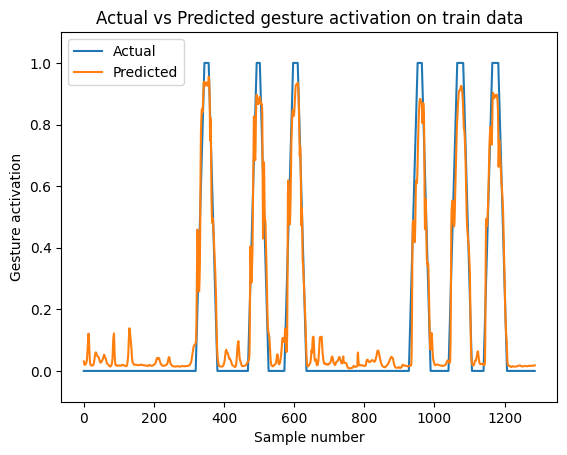

In [136]:
# Get a batch from the test_loader
batches = list(train_loader)

y_pred = torch.zeros(0).to(device)
y_true = torch.zeros(0).to(device)
for batch in batches:
    X, y = batch
    y_true = torch.cat((y_true, y), dim=0)
    y_pred = torch.cat((y_pred, model(X)), dim=0)

y_plot = y_true.cpu().numpy()
y_pred_plot = y_pred.cpu().detach().numpy()

plt.plot(y_plot, label='Actual')
plt.plot(y_pred_plot, label='Predicted')
plt.ylim(-0.1, 1.1)
plt.xlabel("Sample number")
plt.ylabel("Gesture activation")
plt.title("Actual vs Predicted gesture activation on train data")
plt.legend()
plt.show()

In [132]:
# print(model)

In [116]:
# import os
# os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin/'

In [117]:
# from torchviz import make_dot

# batch = next(iter(train_loader))
# yhat = model(batch[0]) 
# make_dot(yhat, params=dict(list(model.named_parameters()))).render("rnn_torchviz", format="svg")